In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# Overview

In the following notebook we compute the Poincaré Map of the three-dimensional, steady ABC-flow. As a benchmark we will use the steady version of the ABC-flow:

\begin{equation}
\begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \\ \dot{z}(t) \end{pmatrix} = \begin{pmatrix} u \\ v \\ w \end{pmatrix} = \begin{pmatrix} A\sin(z)+C\cos(y) \\ B\sin(x) + A\cos(z) \\ C\sin(y)+B\cos(x) \end{pmatrix}, \quad (x,y,z) \in [0, 2\pi]^3
\label{eq: periodicABC} \tag{1}.
\end{equation} 

The parameters are chosen to be: $ A = \sqrt{3}, B = \sqrt{2} $ and $ C = 1 $.

The notebook is structured as follows:

1. Import data from the file 'ABCsteady.mat' stored in the folder 'data/ABC'.
2. Define computational parameters and data.
3. Define spatio-temporal domain.
4. Interpolate velocity from (discrete) gridded data.
5. Poincaré Map:
    
    Compute trajectories launched from $ 10 \times 10 $ equally spaced initial positions on the grid defined by the plane z=0. The time-interval of integration is $ [0, 2\times10^4] $.
    
    Retaining only the long term behaviour of the trajectories over the time-interval $ [10^4, 2\times10^4] $, we sample the trajectories at points which intersect the Poincaré section $ z = 0 $.
5. References

# Discretize velocity field from analytical data

We start by discretizing the velocity field from the steady ABC-flow.

In [2]:
# import scipy
import scipy.io

# import numpy
import numpy as np

def velocity_steady(A, B, C, x, y, z):
    
    u = A*np.sin(z)+C*np.cos(y)
    v = B*np.sin(x)+A*np.cos(z)
    w = C*np.sin(y)+B*np.cos(x)
    
    return u, v, w

def ABC_steady(A, B, C, X, Y, Z):
                
    U, V, W = velocity_steady(A, B, C, X, Y, Z)
        
    return U, V, W 

# define grid of ABC flow
NX = 51
NY = NX
NZ = NY

x = np.linspace(0, 2*np.pi, 51, endpoint = True)
y = x.copy()
z = x.copy()
X, Y, Z = np.meshgrid(x, y, z)

# define constants of ABC flow
A = np.sqrt(3)
B = np.sqrt(2)
C = 1

# compute velocity field for steady ABC flow
U, V, W = ABC_steady(A, B, C, X, Y, Z)

# Computational parameters

Here we define the computational parameters and the analytic velocity field.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 4 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = False # bool

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# import math tools
from math import pi

# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 2*10**4 # float

# Time step-size (in days)
dt = 0.1 # float

# NOTE: For computing the backward trajectories: tN < t0 and dt < 0.

# time array
time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Poincare section z = 0
xmin = 0 # float
xmax = 2*pi # float
ymin = 0 # float
ymax = 2*pi # float
z = 0 # float

# Resolution of meshgrid
Ny = 10 # int
Nx = 10 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is always linear.

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_steady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, Z, U, V, W)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# Poincare map

Using the plane $ z=0 $ as a Poincare section, and placing in it a square grid of $ 10 \times 10 $ initial positions (cf. Fig. 7(a)), we integrate trajectories from time $ [0, 2*10^{4}] $.
Retaining only their long term behaviour from $ [10^{4}, 2*10^{4}] $, we obtain a large number of iterations of the
Poincare map. 

## Integrate trajectories

In [6]:
# Import package for parallel computing
from joblib import Parallel, delayed

# Import function to compute flow map (=trajectories) and derivative of flow map (=velocity along trajectories)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

def parallel_integration_dFdt(x0, y0, z0):
    
    X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)
    
    Fmap = integration_dFdt(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, verbose = True)[0] # array (Nt, 3, Nx*Ny*Nz)
    
    return Fmap

# Split x0,y0,z0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))    

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xy = X_domain.ravel() # array (Nx*Ny, )
y0_xy = Y_domain.ravel() # array (Nx*Ny, )
z0_xy = z*np.ones(x0_xy.shape[0],) # array (Nx*Ny, )

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny*Nz)

results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_integration_dFdt)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

Fmap = results[0]

for res in results[1:]:
    Fmap = np.append(Fmap, res, axis = -1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  9.9min finished


## Compute Poincaré Map
Poincare map obtained from trajectories over $ [10^4, 2*10^4]$ intersecting the plane $ z = 0 $, indicating invariant manifolds of the ABC flow.
The plot reveals 5 vortical regions surrounded by a chaotic sea. Each of the vortical regions contains a family of invariant tori that act as transport barriers.

In [8]:
# Import 1D cubic spline interpolant
from scipy.interpolate import CubicSpline

# Import 1D linear interpolant
from scipy.interpolate import interp1d

t0_poincare = 0.5*time[-1]
tN_poincare = time[-1]

def parallel_PoincareMap(time, Fmap, t0_poincare, tN_poincare):
    
    # CubicSpline Interpolation for x,y and z component of the trajectories
    cs_x = CubicSpline(time, Fmap[:,0])
    cs_y = CubicSpline(time, Fmap[:,1])
    cs_z = CubicSpline(time, Fmap[:,2])
    
    dt = time[1]-time[0]
    
    # time-interval (long-term behaviour of trajectories)
    time_poincare = np.arange(t0_poincare, tN_poincare, dt)
    
    # evaluate long-term behaviour of x,y and z component
    x_interp = cs_x(time_poincare)
    y_interp = cs_y(time_poincare)
    z_interp = cs_z(time_poincare)
    
    x_intersec, y_intersec, z_intersec = [], [], []
    
    coord_interp = z_interp
    
    # iterate along long-term trajectories 
    for i in range(len(coord_interp)-1):
        
        # if intersection then compute intersection point.
        if np.abs(coord_interp[i]%(2*pi)-coord_interp[i+1]%(2*pi)) > pi:
            
            coord_interp_shifted = coord_interp[i:i+2]-np.around((coord_interp[i]/(2*pi)), 0)*2*pi
            
            root = -coord_interp_shifted[0]*dt/(coord_interp_shifted[1]-coord_interp_shifted[0])+time_poincare[i]
            x_intersec.append(cs_x(root)%(2*pi))
            y_intersec.append(cs_y(root)%(2*pi))
            z_intersec.append(cs_z(root)%(2*pi))
    
    return x_intersec, y_intersec, z_intersec

results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_PoincareMap)(time, Fmap[:,:,i], t0_poincare, tN_poincare) for i in range(Fmap.shape[2]))

x_intersec, y_intersec, z_intersec = [], [], []

for res in results:
    for i in range(len(res[0])):
        x_intersec.append(res[0][i])
        y_intersec.append(res[1][i])
        z_intersec.append(res[2][i])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.9s finished


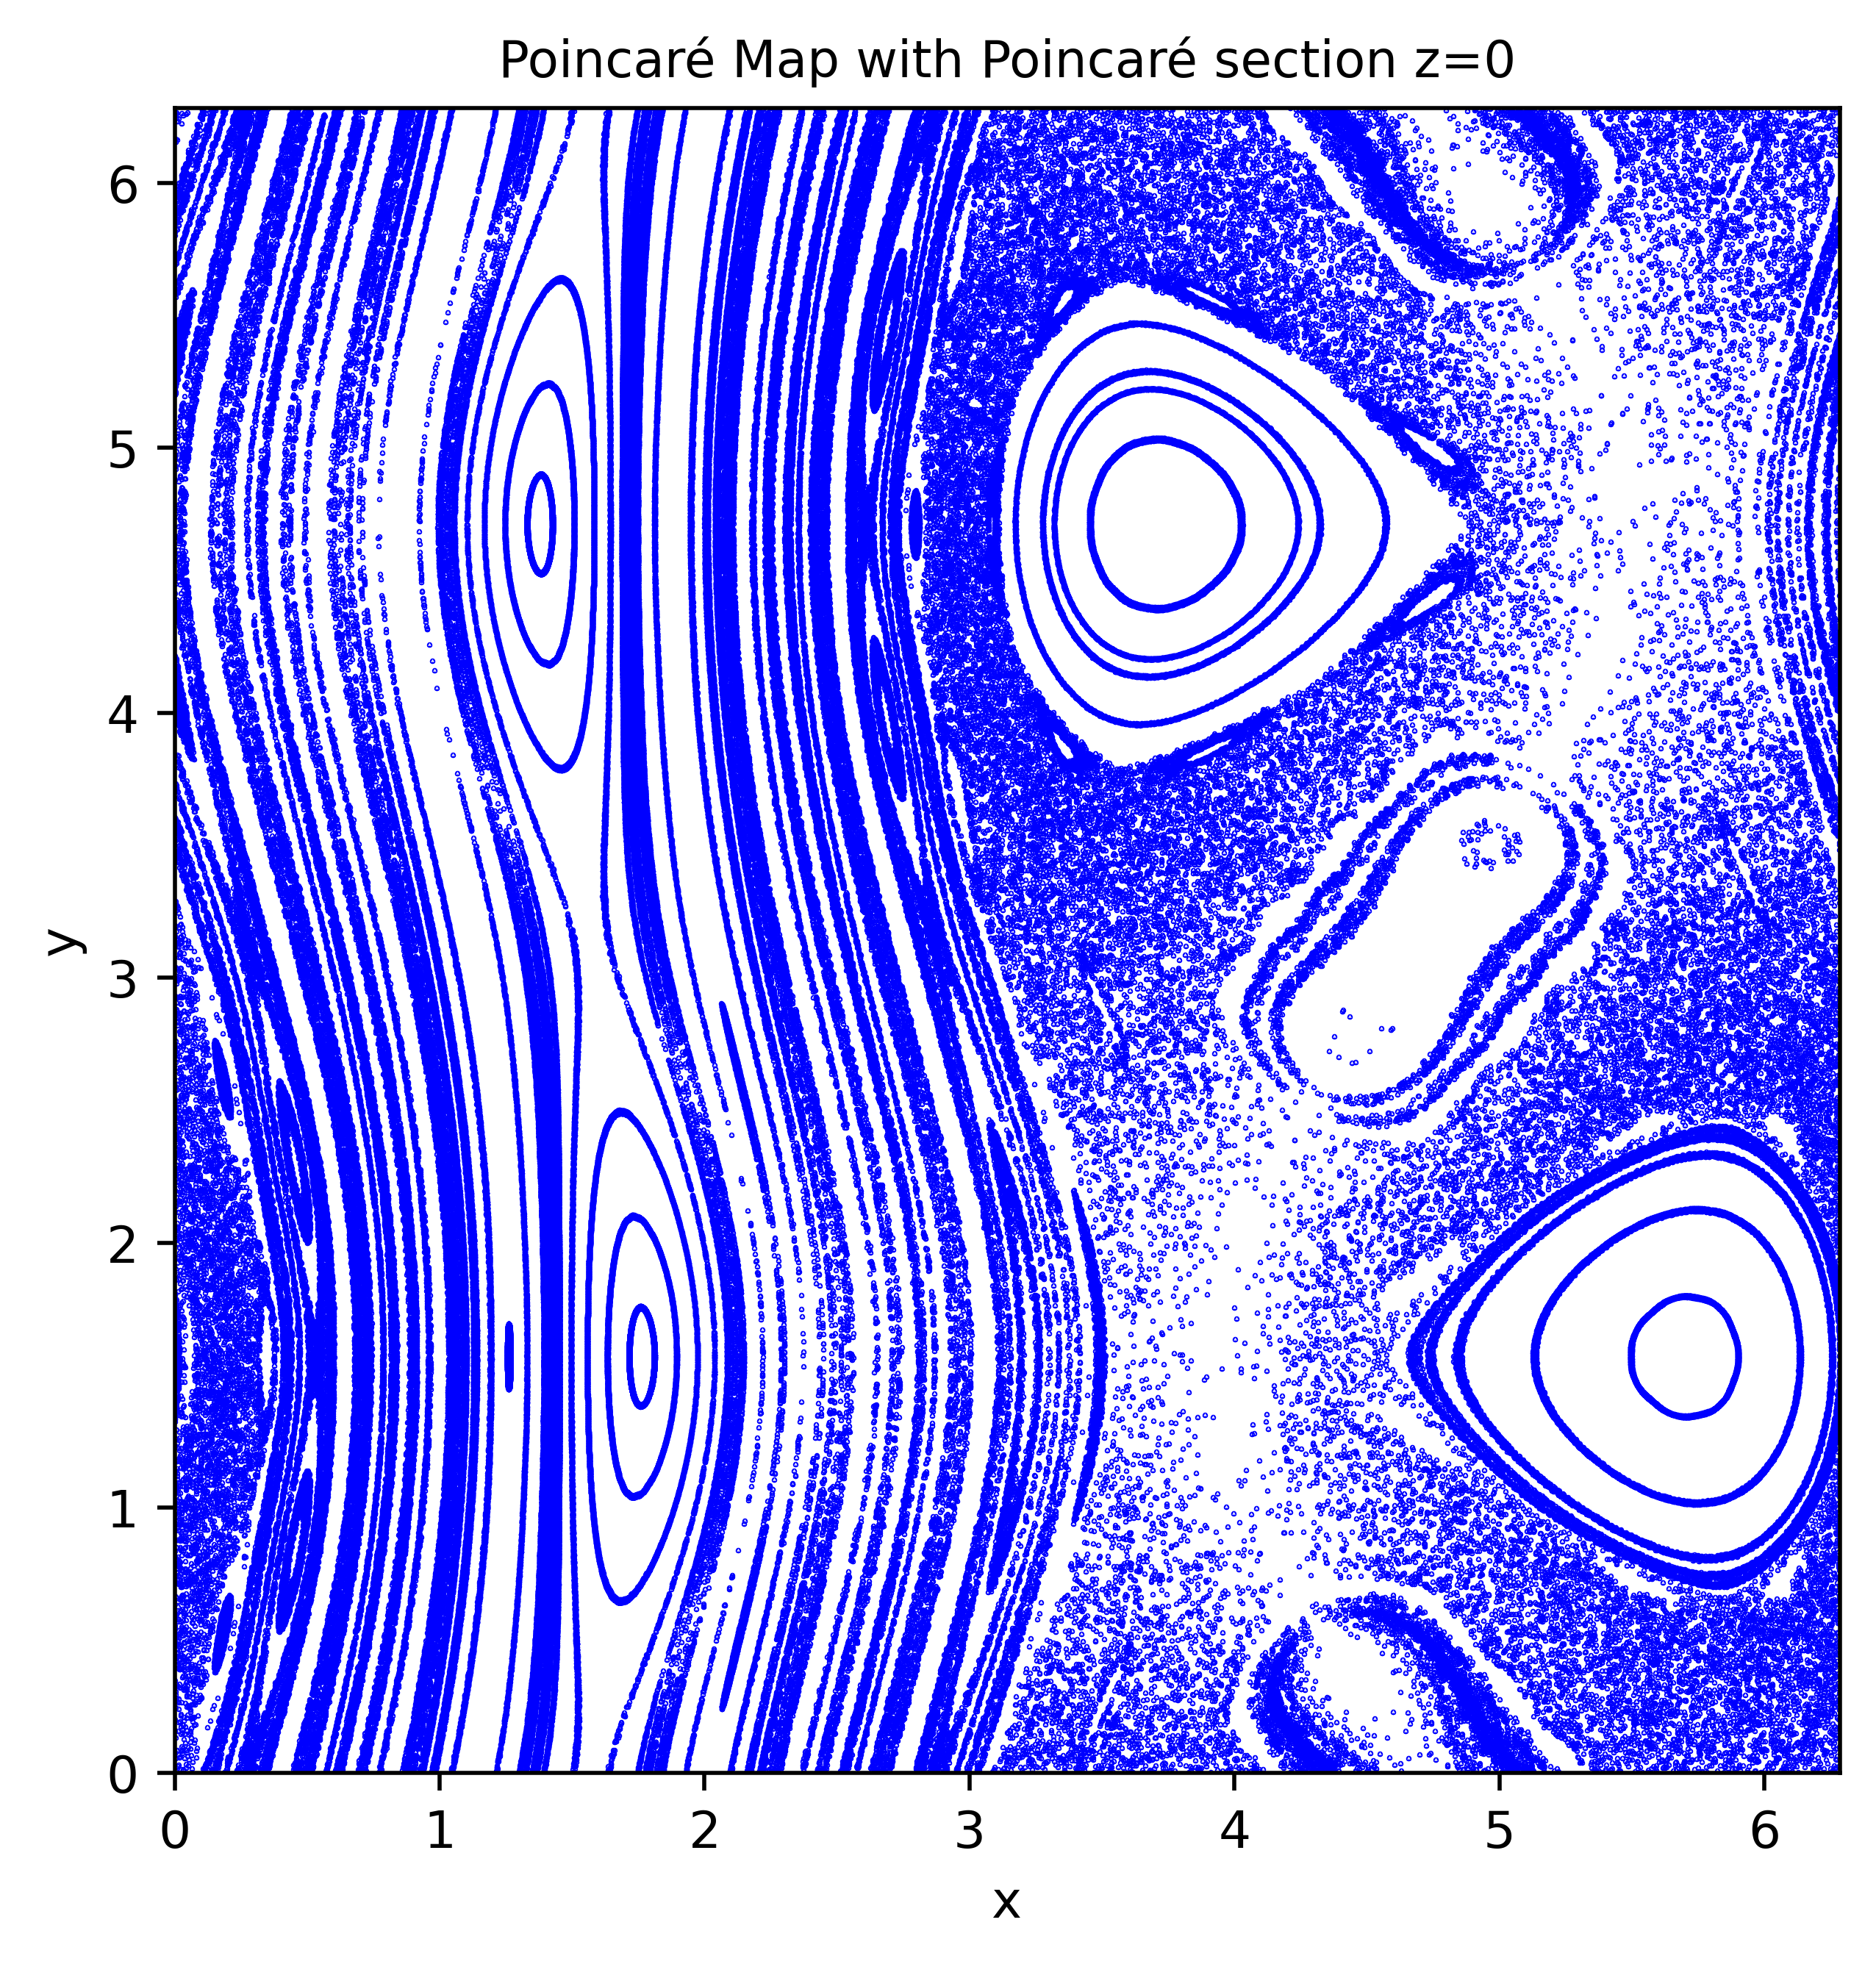

In [9]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(6, 6), dpi = 500)
ax = plt.axes()

# Poincare Map
ax.scatter(x_intersec, y_intersec, c = "b", s = 0.01, marker = "^")

# Axis Labels
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Axis limits
ax.set_xlim([0, 2*pi])
ax.set_ylim([0, 2*pi])

# Title
ax.set_title(r'Poincaré Map with Poincaré section z=0', fontsize = 10)

ax.set_aspect('equal')

plt.show()

The plot reveals vortical regions surrounded by a chaotic sea. Each of the vortical regions contains a family of invariant tori that act as transport barriers.

# References

[1] Notebook 2.2. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.

[2] [YouTube Tutorial](https://youtu.be/P9ZWlaQGnRI)